# **IMPORT**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.functional as F

import json
import os
import torch

os.chdir('F:\\UNIVERSITY\\UNIVERSITY_DOCUMENTS\\CS231\\doan_v2')

from skimage import io, transform
from tqdm import tqdm
from torch import nn
from torch import optim

from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain, MultiOutputClassifier, MultiOutputRegressor 
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, Sigmoid, Softmax, Dropout, Sequential

from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from torchvision.models import vgg16, resnet50, densenet169
from torchvision.models.vgg import VGG16_Weights

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **FUNCTION**

In [2]:
# Load json
def load_json(path):
    with open(path, 'r', encoding='utf-8') as file:
        film_dic = json.load(file)
        return film_dic

# **DATASET**

In [3]:
classes = [
    'action', 'adventure', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'horror', 'mystery', 'thriller', 'romance', 'scifi', 'others'
]

config = {
    'img_size': (224, 224),
    'epochs': 10,
    'batches': 10,
}

In [4]:
# [
#     action, adventure, comedy, crime, documentary, drama, fantasy, horror, mystery, thriller, romance, scifi, others
# ]

In [5]:
class MovieGenreDataset():
    def __init__(
            self, 
            annot_path='data/train.json',
            features_dir='features_VGG',
            classes=[
                'action', 'adventure', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'horror', 'mystery', 'thriller', 'romance', 'scifi', 'others'
            ],
        ) -> None:
        annotation = load_json(annot_path)
        set_name = os.path.basename(annot_path).split('.')[0]

        npy_features_name = os.listdir(features_dir)
        npy_file_names = [f'{id}.npy' for id in annotation.keys() if f'{id}.npy' in npy_features_name]
        
        # Load y
        mlb = MultiLabelBinarizer()
        mlb.fit([classes])

        genres = [
            val['genre'] 
            for id, val in tqdm(annotation.items(), desc="Loading y")
            if f'{id}.npy' in npy_features_name
        ]
        self.y = mlb.transform(genres)

    def get_data(self):
        return self.y
        

# **LOAD DATASET**

## *VGG*

In [6]:
train_VGG_dataset = MovieGenreDataset(
    annot_path='data/train_new.json',
    features_dir='features_VGG',
)

val_VGG_dataset = MovieGenreDataset(
    annot_path='data/val.json',
    features_dir='features_VGG',
)

test_VGG_dataset = MovieGenreDataset(
    annot_path='data/test.json',
    features_dir='features_VGG',
)

Loading y: 100%|██████████| 2512/2512 [00:01<00:00, 2412.32it/s]


In [7]:
# y_train_VGG = train_VGG_dataset.get_data()
# y_val_VGG = val_VGG_dataset.get_data()
y_test_VGG = test_VGG_dataset.get_data()

## *DENSE*

In [8]:
train_Densenet169_dataset = MovieGenreDataset(
    annot_path='data/train_new.json',
    features_dir='features_Densenet169',
)

val_Densenet169_dataset = MovieGenreDataset(
    annot_path='data/val.json',
    features_dir='features_Densenet169',
)

test_Densenet169_dataset = MovieGenreDataset(
    annot_path='data/test.json',
    features_dir='features_Densenet169',
)

Loading y: 100%|██████████| 2512/2512 [00:00<00:00, 3116.63it/s]


In [9]:
# y_train_Densenet = train_Densenet169_dataset.get_data()
# y_val_Densenet = val_Densenet169_dataset.get_data()
y_test_Densenet = test_Densenet169_dataset.get_data()

## *RESNET*

In [10]:
train_Resnet50_dataset = MovieGenreDataset(
    annot_path='data/train_new.json',
    features_dir='features_Resnet50',
)

val_Resnet50_dataset = MovieGenreDataset(
    annot_path='data/val.json',
    features_dir='features_Resnet50',
)

test_Resnet50_dataset = MovieGenreDataset(
    annot_path='data/test.json',
    features_dir='features_Resnet50',
)

Loading y: 100%|██████████| 2512/2512 [00:00<00:00, 4189.68it/s]


In [11]:
# y_train_Resnet = train_Resnet50_dataset.get_data()
# y_val_Resnet = val_Resnet50_dataset.get_data()
y_test_Resnet = test_Resnet50_dataset.get_data()

# **GET EVALUATION**

In [12]:
evaluation_dir = 'evaluation'
names = ['vgg', 'dense', 'resnet']
models = ['rf', 'logistic_r', 'svc']
true_labels = [y_test_VGG, y_test_Densenet, y_test_Resnet]
file_template = f'prediction_logistic_r_dense_test.npy'

evaluation_results = {}
for model in models:
    evaluation_results[model] = {}
    for name in names:
        evaluation_results[model][name] = {
            'prediction': None,
            'f1': None,
            'acc': None,
        }
evaluation_results['rf']['vgg']

{'prediction': None, 'f1': None, 'acc': None}

In [13]:
os.chdir('F:\\UNIVERSITY\\UNIVERSITY_DOCUMENTS\\CS231\\doan_v2')
for true_label, (model_name, backbones_dic) in zip(true_labels, evaluation_results.items()):
    for backbone in backbones_dic.keys():
        path = f'prediction_{model_name}_{backbone}_test.npy'
        result = np.load(os.path.join(evaluation_dir, path)) 
        evaluation_results[model_name][backbone]['prediction'] = result[:2511]
        evaluation_results[model_name][backbone]['true'] = true_label[:2511]
        print(f'Load model_name and its backbone: {model_name} - {backbone}')

Load model_name and its backbone: rf - vgg
Load model_name and its backbone: rf - dense
Load model_name and its backbone: rf - resnet
Load model_name and its backbone: logistic_r - vgg
Load model_name and its backbone: logistic_r - dense
Load model_name and its backbone: logistic_r - resnet
Load model_name and its backbone: svc - vgg
Load model_name and its backbone: svc - dense
Load model_name and its backbone: svc - resnet


# **METRICS**

In [29]:
from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score, classification_report, roc_auc_score, multilabel_confusion_matrix

In [16]:
a = [1, 1, 1]
b = [0, 1, 1]
confusion_matrix(a, b)

array([[0, 0],
       [1, 2]], dtype=int64)

In [31]:
import numpy as np
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def calculate_confusion_matrix(y_true, y_pred):
    confusion_matrices = {}
    # Ensure both y_true and y_pred are 2D arrays (i.e., matrix form)
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(1, -1)
    if len(y_pred.shape) == 1:
        y_pred = y_pred.reshape(1, -1)
        
    num_labels = y_true.shape[1]  # Number of labels (columns)
    print(f'Num labels: {num_labels}')
    
    for i in range(num_labels):
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        confusion_matrices[i] = cm
        
    return confusion_matrices

a = np.array([[1, 1, 1], [1, 1, 1]])
b = np.array([[0, 1, 1], [0, 1, 1]])

# Calculate multilabel confusion matrix directly
result = multilabel_confusion_matrix(a, b)
print(result)


[[[0 0]
  [2 0]]

 [[0 0]
  [0 2]]

 [[0 0]
  [0 2]]]
Num labels: 3
{0: array([[0, 0],
       [2, 0]], dtype=int64), 1: array([[2]], dtype=int64), 2: array([[2]], dtype=int64)}


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [25]:
a = np.array([1, 1, 1]).reshape(-1, 1)
a.shape

(3, 1)

In [54]:
def thresholding_results(y_logits, thres=0.5):
    y_logits_copy = y_logits.copy()
    y_logits_copy[y_logits_copy >= thres] = 1
    y_logits_copy[y_logits_copy < thres] = 0
    return y_logits_copy

for threshold in [0.25, 0.5, 0.75]:
    for model_name, backbones_dic in evaluation_results.items():
        for backbone in backbones_dic.keys():
            pred = evaluation_results[model_name][backbone]['prediction']
            true = evaluation_results[model_name][backbone]['true']
            pred = thresholding_results(pred, thres=threshold)
            if threshold not in evaluation_results[model_name][backbone].keys():
                evaluation_results[model_name][backbone][threshold] = {}
            evaluation_results[model_name][backbone][threshold]['f1_score'] = round(f1_score(true, pred, average='macro'), 2)
            evaluation_results[model_name][backbone][threshold]['precision_score'] = round(precision_score(true, pred, average='macro'), 2)
            evaluation_results[model_name][backbone][threshold]['recall_score'] = round(recall_score(true, pred, average='macro'), 2)
            evaluation_results[model_name][backbone][threshold]['hamming_loss'] = round(hamming_loss(true, pred), 2)
            evaluation_results[model_name][backbone][threshold]['classification_report'] = classification_report(true, pred)
            evaluation_results[model_name][backbone][threshold]['multilabel_confusion_matrix'] = multilabel_confusion_matrix(true, pred)


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [33]:
for threshold in [0.5]:
    for model_name, backbones_dic in evaluation_results.items():
        for backbone in backbones_dic.keys():
            metrics_results = evaluation_results[model_name][backbone][threshold]
            # metrics_results.remove('classification_report')
            print(f'{model_name} - {backbone} - {threshold}: {metrics_results}')

rf - vgg - 0.5: {'f1_score': 0.09, 'precision_score': 0.36, 'recall_score': 0.07, 'hamming_loss': 0.22, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       475\n           1       0.00      0.00      0.00       318\n           2       0.57      0.07      0.12       640\n           3       0.00      0.00      0.00       375\n           4       0.54      0.06      0.11       508\n           5       0.54      0.47      0.50      1051\n           6       0.00      0.00      0.00       226\n           7       0.57      0.05      0.09       569\n           8       0.00      0.00      0.00       463\n           9       0.48      0.09      0.15       850\n          10       0.70      0.07      0.12       600\n          11       0.60      0.01      0.01       525\n          12       0.66      0.07      0.13       749\n\n   micro avg       0.55      0.10      0.17      7349\n   macro avg       0.36      0.07      0.

In [34]:
print(evaluation_results['rf']['vgg'][0.25]['classification_report'])

              precision    recall  f1-score   support

           0       0.33      0.27      0.30       475
           1       0.25      0.12      0.17       318
           2       0.43      0.55      0.48       640
           3       0.23      0.13      0.17       375
           4       0.33      0.49      0.39       508
           5       0.43      0.95      0.59      1051
           6       0.07      0.02      0.03       226
           7       0.33      0.58      0.42       569
           8       0.20      0.14      0.17       463
           9       0.35      0.86      0.50       850
          10       0.42      0.56      0.48       600
          11       0.38      0.35      0.36       525
          12       0.35      0.73      0.47       749

   micro avg       0.37      0.55      0.44      7349
   macro avg       0.31      0.44      0.35      7349
weighted avg       0.34      0.55      0.40      7349
 samples avg       0.38      0.56      0.42      7349



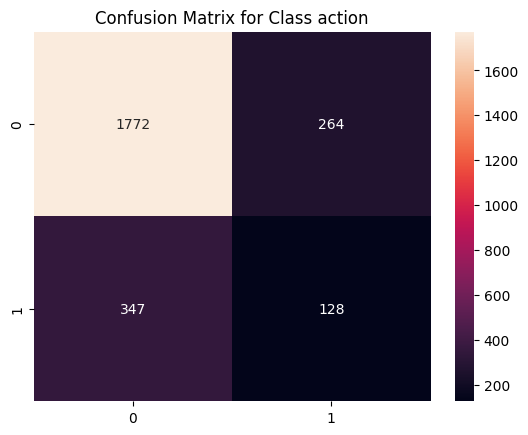

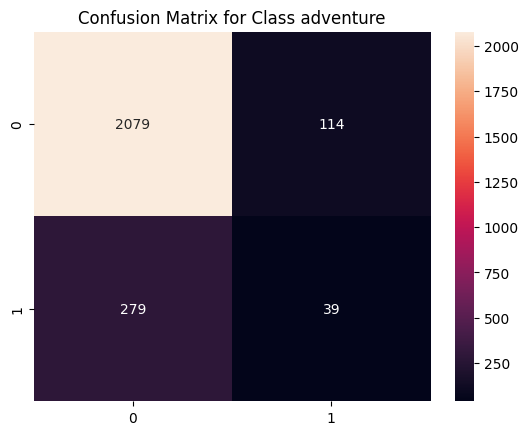

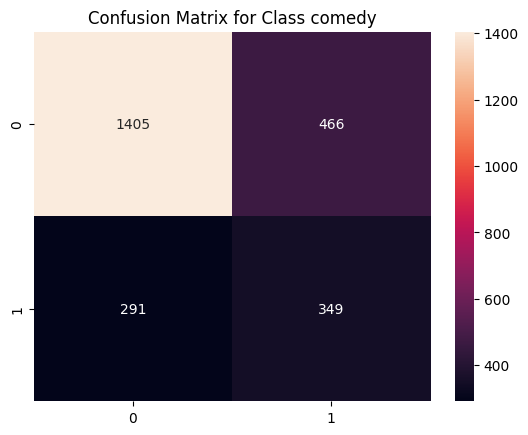

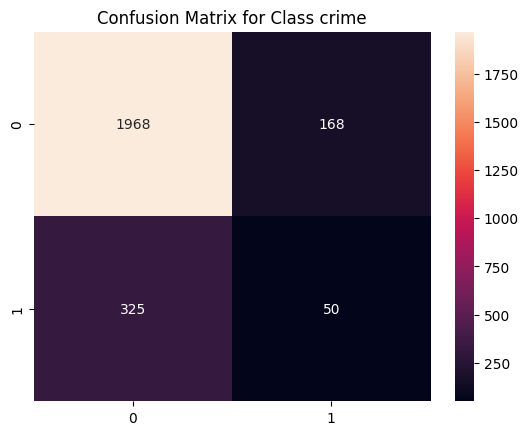

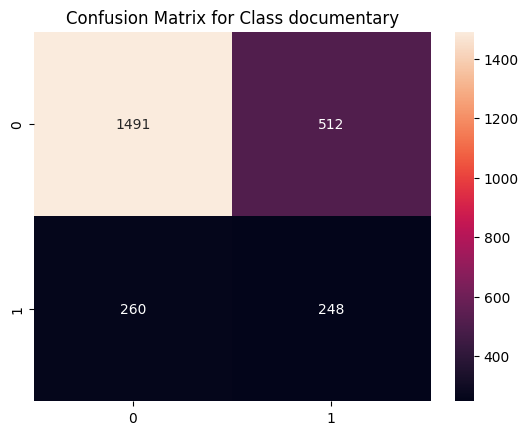

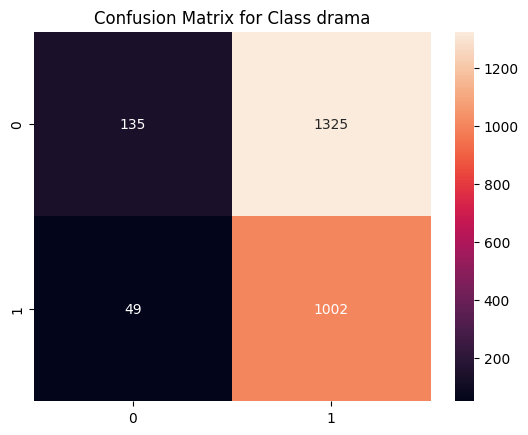

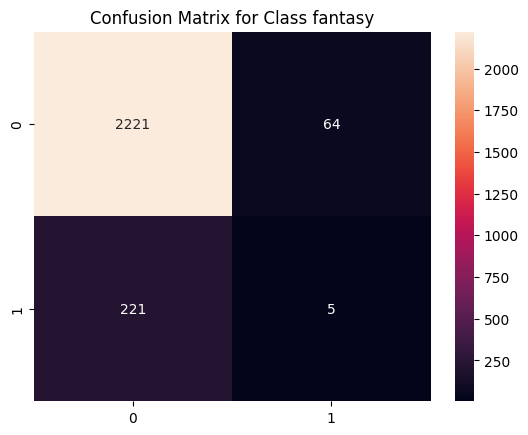

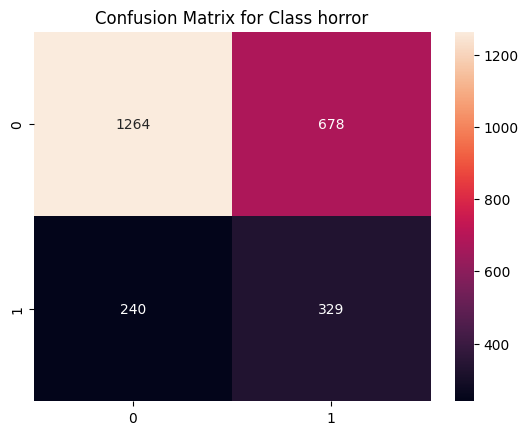

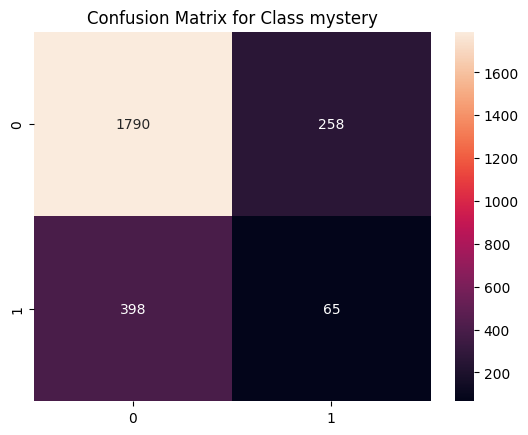

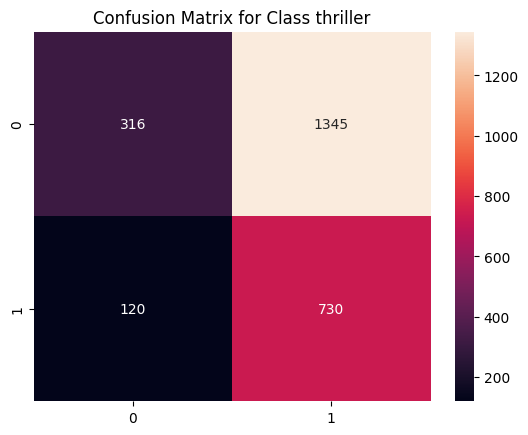

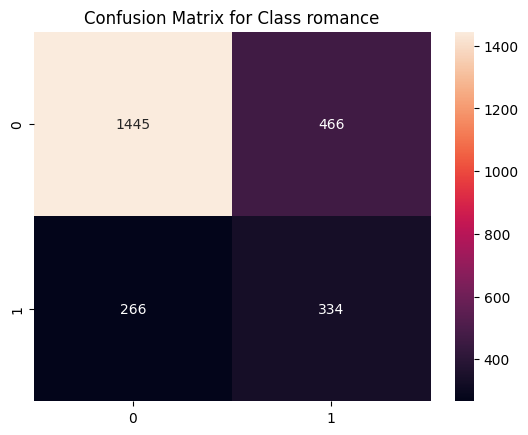

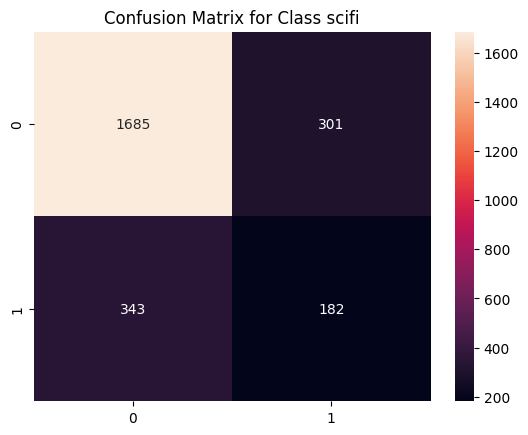

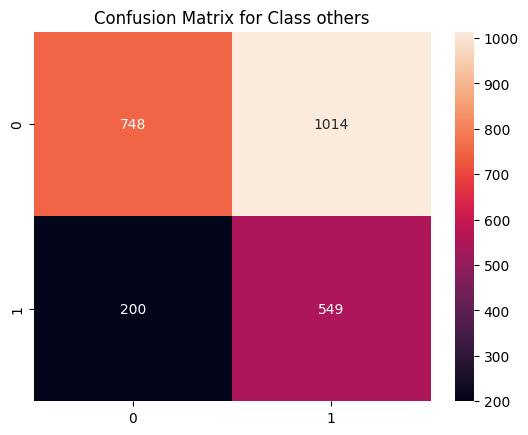

In [55]:
best_cm_output_classifier = evaluation_results['rf']['vgg'][0.25]['multilabel_confusion_matrix']
import seaborn as sns
for c, cm, in zip(classes, best_cm_output_classifier):
    sns.heatmap(cm, annot=True,fmt='.0f')
    plt.title(f'Confusion Matrix for Class {c}')
    plt.show()

In [18]:
classes=[
    'action', 'adventure', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'horror', 'mystery', 'thriller', 'romance', 'scifi', 'others'
]
genre2id = {genre:id for id, genre in enumerate(classes)}
genre2id

{'action': 0,
 'adventure': 1,
 'comedy': 2,
 'crime': 3,
 'documentary': 4,
 'drama': 5,
 'fantasy': 6,
 'horror': 7,
 'mystery': 8,
 'thriller': 9,
 'romance': 10,
 'scifi': 11,
 'others': 12}

# **GET FINAL LABEL**

In [36]:
evaluation_dir = 'evaluation'
names = ['vgg', 'dense', 'resnet']
true_labels = [y_test_VGG, y_test_Densenet, y_test_Resnet]
file_template = f'prediction_logistic_r_dense_test.npy'

evaluation_results_classifier = {}
for name in names:
    evaluation_results_classifier[name] = {
        'prediction': None,
        'f1': None,
        'acc': None,
    }

In [37]:
os.chdir('F:\\UNIVERSITY\\UNIVERSITY_DOCUMENTS\\CS231\\doan_v2\\evaluation')
for name in names:
    path_pred = f'{name}_layer.npy'
    path_true = f'y_test_{name}_layer.npy'
    pred = np.load(path_pred)
    true = np.load(path_true)

    evaluation_results_classifier[name]['prediction'] = pred
    evaluation_results_classifier[name]['true'] = true

In [38]:
def thresholding_results(y_logits, thres=0.5):
    y_logits_copy = y_logits.copy()
    y_logits_copy[y_logits_copy >= thres] = 1
    y_logits_copy[y_logits_copy < thres] = 0
    return y_logits_copy

for threshold in [0.25, 0.5, 0.75]:
    for name in names:
        pred = evaluation_results_classifier[name]['prediction']
        true = evaluation_results_classifier[name]['true']
        pred = thresholding_results(pred, thres=threshold)
        if threshold not in evaluation_results_classifier[name].keys():
            evaluation_results_classifier[name][threshold] = {}
        evaluation_results_classifier[name][threshold]['f1_score'] = round(f1_score(true, pred, average='macro'), 2)
        evaluation_results_classifier[name][threshold]['precision_score'] = round(precision_score(true, pred, average='macro'), 2)
        evaluation_results_classifier[name][threshold]['recall_score'] = round(recall_score(true, pred, average='macro'), 2)
        evaluation_results_classifier[name][threshold]['hamming_loss'] = round(hamming_loss(true, pred), 2)
        evaluation_results_classifier[name][threshold]['classification_report'] = classification_report(true, pred)
        evaluation_results_classifier[name][threshold]['multilabel_confusion_matrix'] = multilabel_confusion_matrix (true, pred)


In [39]:
for threshold in [0.25, 0.5, 0.75]:
    for model_name, val in evaluation_results_classifier.items():
        metrics_results = val[threshold]
        # metrics_results.remove('classification_report')
        print(f'{model_name} - {threshold}: {metrics_results}')

vgg - 0.25: {'f1_score': 0.4, 'precision_score': 0.36, 'recall_score': 0.53, 'hamming_loss': 0.32, 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.40      0.44      0.42       475\n           1       0.34      0.21      0.26       318\n           2       0.47      0.51      0.49       641\n           3       0.25      0.27      0.26       375\n           4       0.37      0.41      0.39       508\n           5       0.42      1.00      0.59      1051\n           6       0.23      0.06      0.10       226\n           7       0.43      0.55      0.48       569\n           8       0.22      0.64      0.33       463\n           9       0.34      1.00      0.51       850\n          10       0.46      0.56      0.51       600\n          11       0.43      0.43      0.43       525\n          12       0.36      0.78      0.50       750\n\n   micro avg       0.37      0.62      0.46      7351\n   macro avg       0.36      0.53      0.40   

In [40]:
print(evaluation_results_classifier['vgg'][0.25]['classification_report'])

              precision    recall  f1-score   support

           0       0.40      0.44      0.42       475
           1       0.34      0.21      0.26       318
           2       0.47      0.51      0.49       641
           3       0.25      0.27      0.26       375
           4       0.37      0.41      0.39       508
           5       0.42      1.00      0.59      1051
           6       0.23      0.06      0.10       226
           7       0.43      0.55      0.48       569
           8       0.22      0.64      0.33       463
           9       0.34      1.00      0.51       850
          10       0.46      0.56      0.51       600
          11       0.43      0.43      0.43       525
          12       0.36      0.78      0.50       750

   micro avg       0.37      0.62      0.46      7351
   macro avg       0.36      0.53      0.40      7351
weighted avg       0.38      0.62      0.45      7351
 samples avg       0.37      0.62      0.44      7351



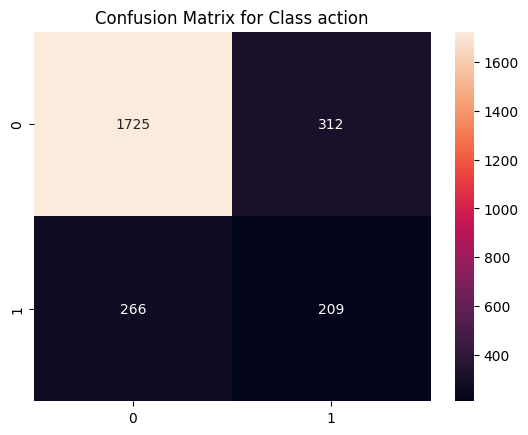

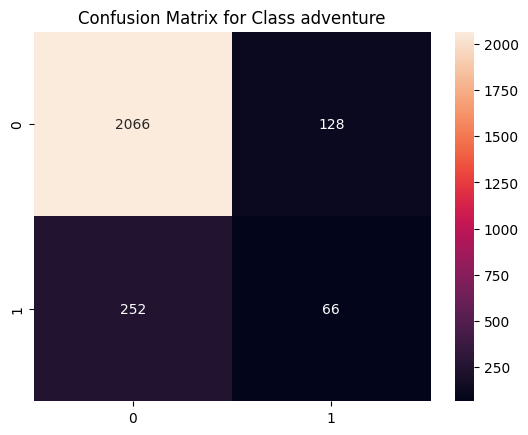

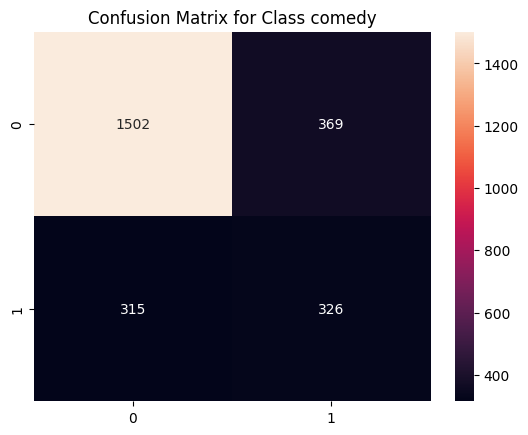

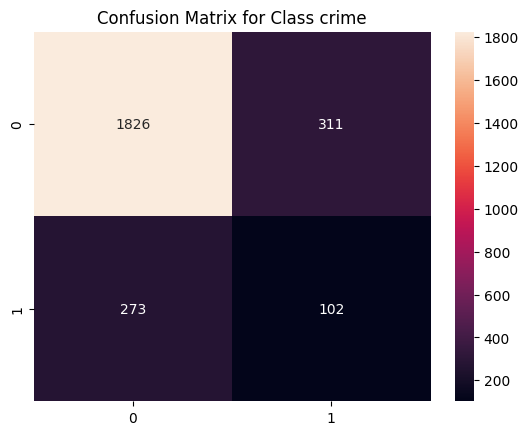

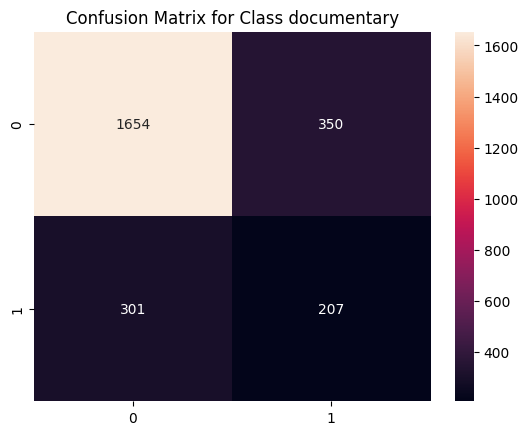

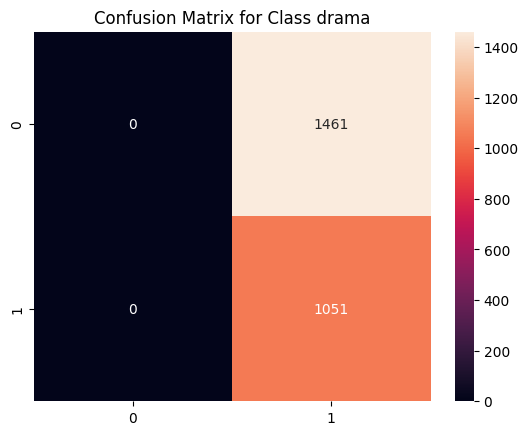

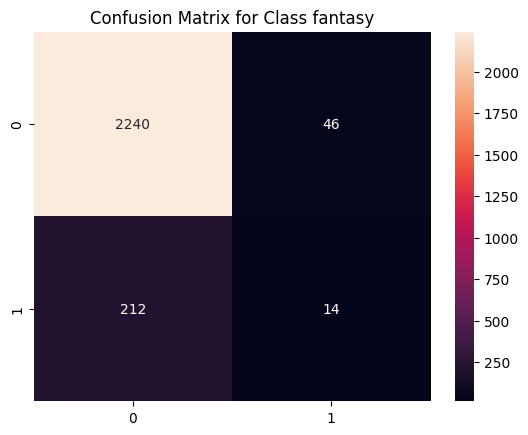

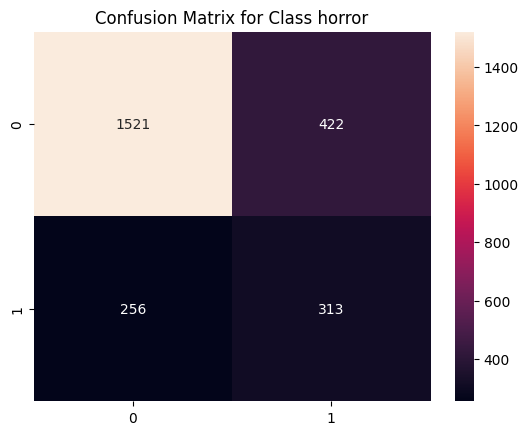

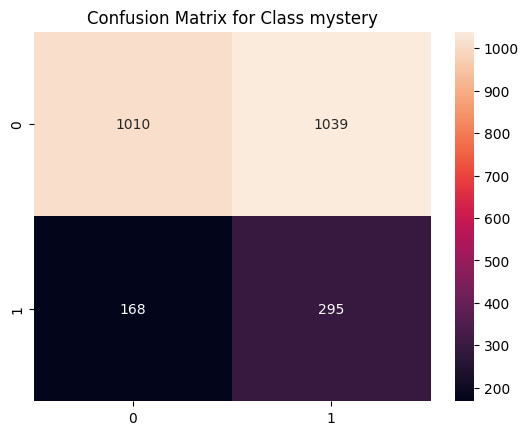

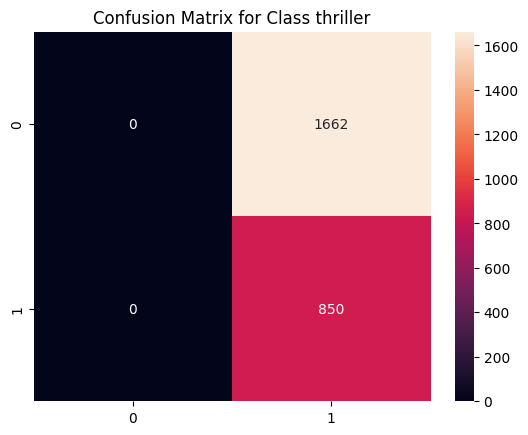

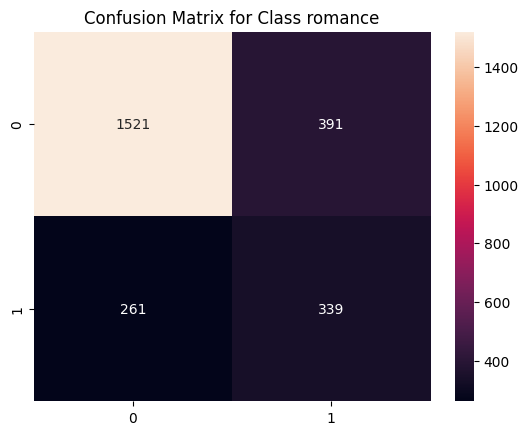

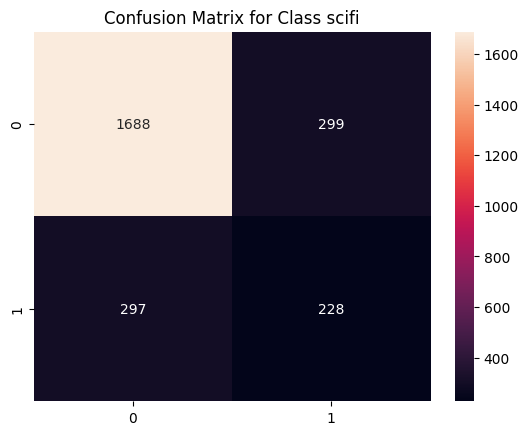

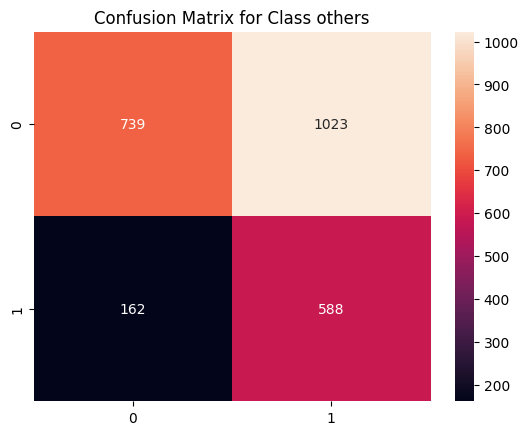

In [51]:
best_cm = evaluation_results_classifier['vgg'][0.25]['multilabel_confusion_matrix']
import seaborn as sns
for c, cm, in zip(classes, best_cm):
    sns.heatmap(cm, annot=True,fmt='.0f')
    plt.title(f'Confusion Matrix for Class {c}')
    plt.show()